In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cosmocnc as cnc
import time
from astropy.io import fits
import pyccl as ccl

2025-05-07 12:28:12.020487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746613692.033464 3444535 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746613692.037115 3444535 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


defaulting to  /rds-d4/user/iz221/hpc-work/cosmopower/
defaulting to  /home/anicola_hpc/projects/ACT_clustering/code/cosmocnc/cosmocnc/../


In [2]:
number_counts = cnc.cluster_number_counts()

number_counts.cnc_params["survey_sr"] = "/home/anicola_hpc/projects/ACT_clustering/scripts/survey_sr_act_DES.py"
number_counts.cnc_params["survey_cat"] = None

number_counts.cnc_params["load_catalogue"] = False

number_counts.cnc_params["cluster_catalogue"] = "act"
number_counts.cnc_params["observables"] =  [["q_act"]]
number_counts.cnc_params["obs_select"] = "q_act"

number_counts.cnc_params["data_lik_from_abundance"] = True
number_counts.cnc_params["compute_abundance_matrix"] = True

number_counts.cnc_params["obs_select_min"] = 5.
number_counts.cnc_params["obs_select_max"] = 200.
number_counts.cnc_params["M_min"] = 5e13
number_counts.cnc_params["M_max"] = 1e16
number_counts.cnc_params["z_min"] = 0.01
number_counts.cnc_params["z_max"] = 3.

number_counts.cnc_params["n_points"] = 1024*16
number_counts.cnc_params["n_z"] = 100

number_counts.cnc_params["scalrel_type_deriv"] = "numerical"
number_counts.cnc_params["abundance_integral_type"] = "fft"
number_counts.cnc_params["apply_obs_cutoff"] = False

number_counts.cnc_params["cosmology_tool"] = "classy_sz"
number_counts.cnc_params["hmf_calc"] = "classy_sz"
number_counts.cnc_params["class_sz_hmf"] = "T08M500c"
number_counts.cnc_params["mass_definition"] = "500c"
number_counts.cnc_params["hmf_type_deriv"] = "numerical"
# number_counts.cnc_params["interp_tinker"] = "linear"


number_counts.cnc_params["number_cores_hmf"] = 1
number_counts.cnc_params["number_cores_abundance"] = 1#8
number_counts.cnc_params["number_cores_data"] = 1# 8
number_counts.cnc_params["parallelise_type"] = "redshift"

number_counts.cnc_params["cosmo_amplitude_parameter"] = "sigma_8"
number_counts.cnc_params["Hubble_parameter"] = "H0"
number_counts.cnc_params["cosmo_param_density"] = "physical"
number_counts.cnc_params["class_sz_cosmo_model"] = "mnu"
number_counts.cnc_params["cosmo_model"] = number_counts.cnc_params["class_sz_cosmo_model"]

#    "class_sz_cosmo_model": "lcdm", # lcdm, mnu, neff, wcdm, ede

number_counts.cnc_params["cosmocnc_verbose"] = "minimal"

number_counts.cnc_params["likelihood_type"] = "binned"

number_counts.scal_rel_params["q_cutoff"] = 5.

number_counts.cnc_params["bins_edges_obs_select"] = np.exp(np.linspace(np.log(number_counts.cnc_params["obs_select_min"]), \
                                                                    np.log(number_counts.cnc_params["obs_select_max"]),7))

number_counts.scal_rel_params.update({
'A0' : -4.76 ,
# 'B0': 0.14,
# 'A0' : np.log10(3e-5),
'B0': 0.025,
'SZmPivot' : 3e14, #in Msun
'bias_sz' : 1.,
'sigma_lnq_act' : 0.1,
'C0' : 2.,
"dof":0.,
}
)                                                          

# 68% -4.617 -4.291 
# 95% -4.76 -4.11

# A0  -4.4032137E+00 
# B0   2.4235966E-02  
# sigma_lnq_act 1.0006905E-01

number_counts.cosmo_params.update({

"Ob0h2":0.04897*0.674**2,
"Oc0h2":(0.315-0.04897)*0.674**2,
"h":0.674,
"H0": 67.4,
"sigma8": 0.811,
"tau_reio": 0.0544,
"n_s":0.96,
"m_nu":0.06,
"A_s":2.08467e-09,
}
)


In [3]:
A0_vec = np.array([-4.76, -4.62, -4.4, -4.3, -4.11])

In [4]:
# Delta=200 (matter).
hmd_200m = ccl.halos.MassDef200m

# Delta=500 (matter).
hmd_500c = ccl.halos.MassDef(500, 'critical')

mass_trans = ccl.halos.mass_translator(mass_in=hmd_200m, mass_out=hmd_500c, 
                                       concentration=ccl.halos.ConcentrationDuffy08(mass_def=hmd_200m))

In [5]:
cosmo = ccl.Cosmology(Omega_b=0.04897, Omega_c=0.315-0.04897, h=0.674, A_s=2.08467e-09, n_s=0.96)

In [6]:
m200m_arr = np.logspace(14, 15, 100)

m500c = mass_trans(cosmo, m200m_arr, 1.)

In [7]:
ym_rels = []
n_binned_snr_theory = []
n_binned_z_theory = []

number_counts.initialise()

for i in range(len(A0_vec)):
    print("A0 = ", A0_vec[i])
    number_counts.scal_rel_params.update({
        'A0' : A0_vec[i],
        # 'B0': 0.14,
        # 'A0' : np.log10(3e-5),
        'B0': 0.025,
        'SZmPivot' : 3e14, #in Msun
        'bias_sz' : 1.,
        'sigma_lnq_act' : 0.1,
        'C0' : 2.,
        "dof":0.,
        }
        )

    number_counts.update_params(number_counts.cosmo_params,number_counts.scal_rel_params, number_counts.cnc_params)
    
    number_counts.initialise()

    number_counts.get_number_counts()  

    x0 = np.log(m500c/1e14)

    x1 = np.zeros((49, 100))

    redshift_index = 0

    other_params = {"D_A": number_counts.D_A[redshift_index],
                                            "E_z": number_counts.E_z[redshift_index],
                                            "H0": number_counts.cosmology.background_cosmology.H0.value,
                                            "E_z0p6" : number_counts.E_z0p6,
                                            "zc":number_counts.redshift_vec[redshift_index],
                                            "cosmology":number_counts.cosmology,
                                            }

    for i in range(49):

        number_counts.scal_rel_selection.precompute_scaling_relation(params=number_counts.scal_rel_params,
                                                                            other_params=other_params,
                                                                            patch_index=i)

        x1[i, :] = number_counts.scal_rel_selection.eval_scaling_relation(x0,
                                                            layer=0,
                                                            other_params=other_params,
                                                            patch_index=i)    

    ym_rels.append(np.average(np.exp(x1), axis=0, weights=1./number_counts.scal_rel_selection.noise))

    log_lik = number_counts.get_log_lik()

    bins_centres_z = (number_counts.cnc_params["bins_edges_z"][1:] + number_counts.cnc_params["bins_edges_z"][0:-1])*0.5
    bins_centres_snr = (number_counts.cnc_params["bins_edges_obs_select"][1:] + number_counts.cnc_params["bins_edges_obs_select"][0:-1])*0.5

    n_binned_theory = number_counts.n_binned #Theoretical prediction for the number counts in the SNR-z bins

    n_binned_snr_theory.append(np.sum(n_binned_theory,axis=0)) #Theoretical prediction for the number counts in the SNR bins

    n_binned_z_theory.append(np.sum(n_binned_theory,axis=1)) #Theoretical prediction for the number counts in the z bins

INFO - Cosmology params: {'Om0': 0.315, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.08467e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.811, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.00141808, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
2025-05-07 12:28:14.465433: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


PATH_TO_CLASS_SZ_DATA not set. Setting it now...
Defaulting to: /home/anicola_hpc/class_sz_data_directory


INFO - adding dndlnM to class_sz output
INFO - computing class_szfast
/home/anicola_hpc/.conda/envs/act-clust/lib/python3.11/site-packages/mcfit/mcfit.py:130: UserWarning: use backend='jax' if desired
  warnings.warn("use backend='jax' if desired")
INFO - computing class_szfast done
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


A0 =  -4.76


INFO - computing class_szfast done
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast
INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 448.94738
INFO - Time: 0.09195
INFO - log_lik: -406.26140
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.81

A0 =  -4.62


INFO - computing class_szfast done
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast
INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 1065.40835
INFO - Time: 0.08694
INFO - log_lik: -947.16582
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.8

A0 =  -4.4


INFO - computing class_szfast done
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast
INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 3533.98204
INFO - Time: 0.09134
INFO - log_lik: -3036.51152
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.

A0 =  -4.3


INFO - computing class_szfast done
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast
INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 5774.44710
INFO - Time: 0.08400
INFO - log_lik: -4872.80330
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.

A0 =  -4.11


INFO - computing class_szfast done
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast
INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 13594.49620
INFO - Time: 0.08681
INFO - log_lik: -11036.44365


In [8]:
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['lines.linestyle'] = '-'  
matplotlib.rcParams['lines.color'] = 'black'

matplotlib.rcParams['patch.linewidth'] = 1.5
 
#fonts & text
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.weight'] = 'normal'
matplotlib.rcParams['font.size'] = 12.0
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['text.usetex'] = False
 
#axes & ticks
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = 1.  
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['axes.titlesize'] = 'x-large'
matplotlib.rcParams['axes.labelsize'] = 'x-large'
matplotlib.rcParams['axes.labelweight'] = 'normal'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['axes.formatter.limits'] = [-4, 4]
 
matplotlib.rcParams['xtick.major.size'] = 7
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.major.pad'] = 6
matplotlib.rcParams['xtick.minor.pad'] = 6
matplotlib.rcParams['xtick.labelsize'] = 'small'
matplotlib.rcParams['xtick.minor.width'] = 1.0
matplotlib.rcParams['xtick.major.width'] = 1.0
 
matplotlib.rcParams['ytick.major.size'] = 7
matplotlib.rcParams['ytick.minor.size'] = 4
matplotlib.rcParams['ytick.major.pad'] = 6
matplotlib.rcParams['ytick.minor.pad'] = 6
matplotlib.rcParams['ytick.labelsize'] = 'x-large'
matplotlib.rcParams['ytick.minor.width'] = 1.0
matplotlib.rcParams['ytick.major.width'] = 1.0
 
#legends
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['legend.shadow'] = False
matplotlib.rcParams['legend.frameon'] = False

matplotlib.rcParams['figure.autolayout'] = True

In [9]:
colors = ['#e3a19c', '#85a1ca', '#596d82', '#725e9c', '#3d306b', '#AE7182']

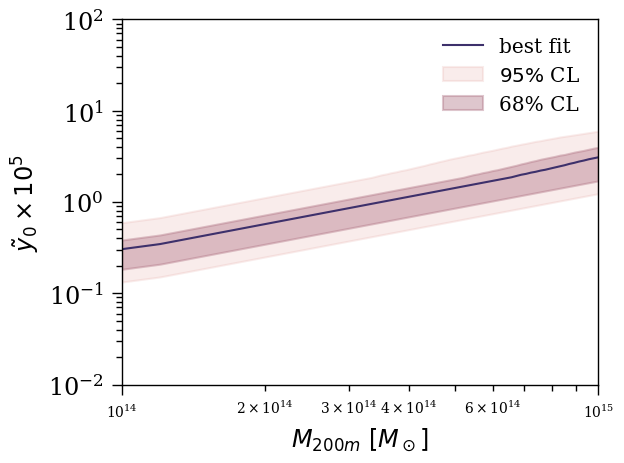

In [10]:
plt.loglog(m200m_arr, ym_rels[2]*1e5, label='best fit', color=colors[4])
plt.fill_between(m200m_arr, ym_rels[0]*1e5, ym_rels[-1]*1e5, label=r'$95\%$ CL', alpha=0.2, color=colors[0])
plt.fill_between(m200m_arr, ym_rels[1]*1e5, ym_rels[3]*1e5, label='68% CL', alpha=0.4, color=colors[-1])
plt.xlim(1e14, 1e15)
plt.ylim(1e-2, 1e2)
plt.xlabel(r"$M_{200m}$ $[M_\odot]$")
plt.ylabel(r"$\tilde{y}_0\times 10^5$")
plt.legend(frameon=False)

In [11]:
file_catalog = '/lustre/scratch/data/anicola_hpc-ACT_clustering/data/DR5ClusterSearch/DR5ClusterSearch_optimalCatalog.fits'

hdulist = fits.open(file_catalog)

cat = hdulist[1].data

Number of clusters in DES footprint

In [12]:
mask = cat['footprint_DES']*(cat['fixed_SNR'] > 5.0)

In [13]:
np.sum(cat['footprint_DES'][cat['fixed_SNR'] > 5.0])

948

In [14]:
data, bin_edges = np.histogram(cat['fixed_SNR'][mask],bins=number_counts.cnc_params["bins_edges_obs_select"])

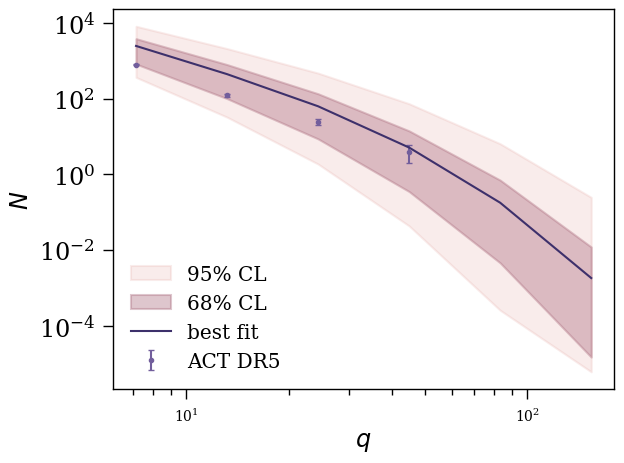

In [15]:
plt.errorbar(0.5*(bin_edges[1:]+bin_edges[:-1]),data, yerr=np.sqrt(data), \
             linestyle="none",marker='.', label='ACT DR5', color=colors[3], capsize=2)
plt.fill_between(bins_centres_snr, n_binned_snr_theory[0], n_binned_snr_theory[-1], alpha=0.2, color=colors[0], label='95% CL')
plt.fill_between(bins_centres_snr, n_binned_snr_theory[1], n_binned_snr_theory[3], alpha=0.4, color=colors[-1], label='68% CL')
plt.plot(bins_centres_snr, n_binned_snr_theory[2], label='best fit', color=colors[4])
plt.xlabel("$q$")
plt.ylabel("$N$")
plt.loglog()
plt.legend(frameon=False)
plt.show()

In [16]:
zc_edges = np.array([0.2, 0.4, 0.55, 0.7, 0.85])

In [17]:
number_counts.initialise()

INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast
INFO - computing class_szfast done


In [18]:
biases = np.zeros((len(A0_vec), len(zc_edges) - 1))

for i in range(len(A0_vec)):
    print("A0 = ", A0_vec[i])
    number_counts.scal_rel_params.update({
        'A0' : A0_vec[i],
        # 'B0': 0.14,
        # 'A0' : np.log10(3e-5),
        'B0': 0.025,
        'SZmPivot' : 3e14, #in Msun
        'bias_sz' : 1.,
        'sigma_lnq_act' : 0.1,
        'C0' : 2.,
        "dof":0.,
        }
        )

    n_tot = 0.

    for j in range(len(zc_edges) - 1):

        number_counts.cnc_params.update({
                "z_min": zc_edges[j],
                "z_max": zc_edges[j+1],
                "bins_edges_z": np.linspace(zc_edges[j], \
                                zc_edges[j+1], 100)
        })

        number_counts.update_params(number_counts.cosmo_params,number_counts.scal_rel_params, number_counts.cnc_params)

        number_counts.get_number_counts() #Evaluate the binned likelihood
        number_counts.get_bias_weighted_cluster_abundance() #Evaluate the binned likelihood

        n_tot_bin = number_counts.n_tot
        n_tot_bias_weighted = number_counts.n_tot_bias_weighted

        biases[i, j] = n_tot_bias_weighted/n_tot_bin

        print('Redshift bin edges: ', zc_edges[j], zc_edges[j+1])
        print('Average bias: ', biases[i, j])
        print('Total number counts bin: ', n_tot_bin)

        n_tot += n_tot_bin

    print('Total number counts: ', n_tot)

INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


A0 =  -4.76


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 115.92060
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.2 0.4
Average bias:  6.1188750684601985
Total number counts bin:  115.92060369097788


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 97.52391
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.4 0.55
Average bias:  6.99997571667805
Total number counts bin:  97.5239122102115


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 78.59379
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.55 0.7
Average bias:  7.842039044427968
Total number counts bin:  78.5937853330309


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 54.36653
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.7 0.85
Average bias:  8.716623130116508
Total number counts bin:  54.36652703604093
Total number counts:  346.4048282702612
A0 =  -4.62


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 261.64199
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.2 0.4
Average bias:  5.505153732276482
Total number counts bin:  261.6419873077474


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 221.14432
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.4 0.55
Average bias:  6.3384612898896755
Total number counts bin:  221.14432357059138


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 183.18628
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.55 0.7
Average bias:  7.124780437162704
Total number counts bin:  183.18628354561926


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 131.48360
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.7 0.85
Average bias:  7.939477681164276
Total number counts bin:  131.48360021507705
Total number counts:  797.4561946390352
A0 =  -4.4


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 791.18225
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.2 0.4
Average bias:  4.698482558124897
Total number counts bin:  791.1822457200684


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 680.90145
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.4 0.55
Average bias:  5.455446535384657
Total number counts bin:  680.901445548813


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 589.91830
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.55 0.7
Average bias:  6.157555986919342
Total number counts bin:  589.918297868096


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 447.77767
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.7 0.85
Average bias:  6.883415128879882
Total number counts bin:  447.7776723038722
Total number counts:  2509.77966144085
A0 =  -4.3


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 1234.20332
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.2 0.4
Average bias:  4.3868743494645335
Total number counts bin:  1234.203318014652


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 1073.93450
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.4 0.55
Average bias:  5.109378311743775
Total number counts bin:  1073.9344977525668


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 949.59026
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.55 0.7
Average bias:  5.775303581397416
Total number counts bin:  949.5902646854672


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 738.44052
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.7 0.85
Average bias:  6.463266436062512
Total number counts bin:  738.4405244378169
Total number counts:  3996.168604890503
A0 =  -4.11


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 2645.56580
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.2 0.4
Average bias:  3.8740348723553026
Total number counts bin:  2645.565798692173


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 2357.55810
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.4 0.55
Average bias:  4.532726752928332
Total number counts bin:  2357.5581010790415


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 2164.24881
INFO - Collecting hmf
INFO - Cosmology params: {'Om0': 0.31499999999999995, 'Ob0': 0.04897, 'Ob0h2': 0.022245895720000002, 'Oc0h2': 0.12085104428000001, 'h': 0.674, 'A_s': 2.0856609249807952e-09, 'n_s': 0.96, 'm_nu': 0.06, 'sigma_8': 0.8110000000000003, 'tau_reio': 0.0544, 'w0': -1.0, 'Onu0': 0.001418083698824921, 'N_eff': 3.046, 'k_cutoff': 100000000.0, 'ps_cutoff': 1, 'H0': 67.4, 'sigma8': 0.811}
INFO - adding dndlnM to class_sz output
INFO - computing class_szfast


Redshift bin edges:  0.55 0.7
Average bias:  5.134203030655436
Total number counts bin:  2164.248809734692


INFO - computing class_szfast done
INFO - Collecting hmf
INFO - Total clusters: 1757.95209
INFO - Collecting hmf


Redshift bin edges:  0.7 0.85
Average bias:  5.754859207262883
Total number counts bin:  1757.9520924199132
Total number counts:  8925.324801925819


In [19]:
z_means = 0.5*(zc_edges[1:] + zc_edges[:-1])

In [20]:
bias_vec = np.array([4.38, 5.22, 7.8, 1.91])
bias_std = np.array([0.67, 0.79, 1.3, 0.87])

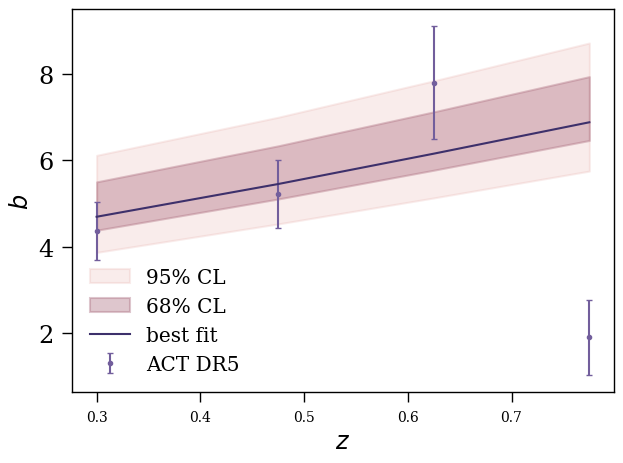

In [21]:
plt.errorbar(z_means, bias_vec, yerr=bias_std, \
             linestyle="none",marker='.', label='ACT DR5', color=colors[3], capsize=2)
plt.fill_between(z_means, biases[0], biases[-1], alpha=0.2, color=colors[0], label='95% CL')
plt.fill_between(z_means, biases[1], biases[3], alpha=0.4, color=colors[-1], label='68% CL')
plt.plot(z_means, biases[2], label='best fit', color=colors[4])
plt.xlabel("$z$")
plt.ylabel("$b$")
plt.legend(frameon=False)
plt.show()